In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt

In [2]:
# Objective function
# WARNING: SafeOpt has issues with negative function values!
def sphere(x): return 100 - ((x**2).sum(axis=-1)) 
fun = sphere 

In [3]:
def eval_on_grid(f, xbound, n_steps):
    # This is similar but simpler than what safeopt.linearly_spaced_combinations does.
    x_steps = np.linspace(xbound[0], xbound[1], n_steps)
    x_mesh = np.array(np.meshgrid(x_steps, x_steps))
    x_matrix = x_mesh.T.reshape(-1, 2)
    # safeopt.linearly_spaced_combinations returns x_matrix[:, ::-1]
    # Another option would be np.apply_along_axis(function, 1, array)
    y = f(x_matrix)
    return x_steps, x_matrix, y

def estimate_lipschitz(f, xbound, n_steps):
    x_steps, x_matrix, y = eval_on_grid(f, xbound=xbound, n_steps = n_steps)
    g1, g2 = np.gradient(y.reshape(n_steps, n_steps), x_steps, x_steps)
    return max(g1.max(), g2.max())

bounds = [(-5., 5.),(-5.,5.)]
n_steps = 500
# For simplicity, we use the same bounds for all variables. This could be extended easily to handle different bounds.
x_steps, x_matrix, y = eval_on_grid(fun, bounds[0], n_steps)
L = estimate_lipschitz(fun, bounds[0], n_steps)
print(f'Lipschitz constant = {L}')
# Setting Safety threshold as 75 percentile
SafeThres = np.quantile(y, 0.75)
print(f'Safe Threshold (.75) = {SafeThres}')
opt_pos = np.argmax(y)
print(f'y_opt = {y[opt_pos]}, x_opt = {x_matrix[opt_pos,:]}')

Lipschitz constant = 9.979959919840175
Safe Threshold (.75) = 92.01027305111225
y_opt = 99.99979919759359, x_opt = [-0.01002004 -0.01002004]


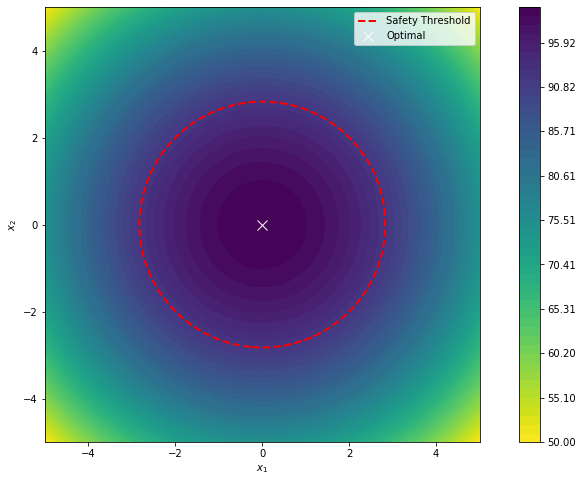

In [4]:
import matplotlib.pyplot as plt
def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(x_1, x_2, y, safe_threshold, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(x_steps,x_steps, y, SafeThres)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)

fig, ax, legend = plot_function(x_steps,x_steps, y, SafeThres)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

Safe seeds:
 X = [[-2.01402806  1.05210421]]
 y = [[94.83676772]]


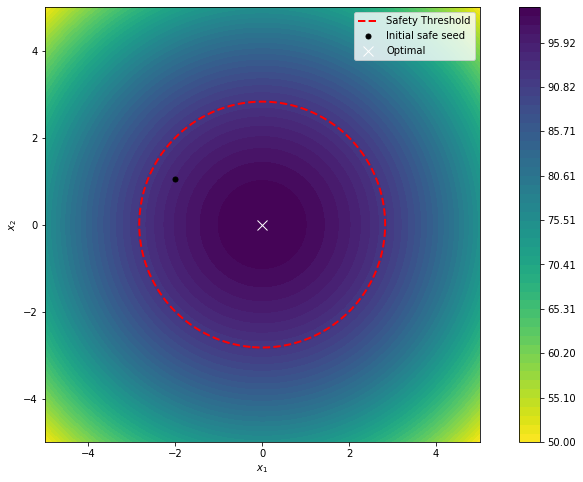

In [5]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)
def get_safe_seeds(x_matrix, y, safe_threshold, n):
    y_safe_mask = y > safe_threshold
    pos = rng.choice(y_safe_mask.sum(), size = n, replace=False)
    x_safe_seed = x_matrix[y_safe_mask,:][pos,:]
    y_safe_seed = y[y_safe_mask][pos]
    y_safe_seed = y_safe_seed[:,None]
    print(f'Safe seeds:\n X = {x_safe_seed}\n y = {y_safe_seed}')
    return x_safe_seed, y_safe_seed 

x_safe_seed, y_safe_seed = get_safe_seeds(x_matrix, y, SafeThres, n=1)

fig, ax, legend = plot_function(x_steps,x_steps, y, SafeThres)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

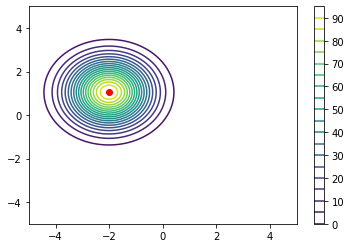

In [6]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={len(opt.y)}\ty={y_meas}\tsafe={y_meas >= SafeThres}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)}')
    
# Measurement noise, I will add the variance soon
noise_var = 0.00 ** 2
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=len(bounds), ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel, noise_var=noise_var)

# The optimization routine
# FIXME: Why beta = 1.96 ?
# FIXME: It is not clear what is threshold
opt = safeopt.SafeOpt(gp, parameter_set=x_matrix, fmin=[SafeThres], lipschitz=L, beta = 1.96, threshold=0)
# here, use lipschitz=None for modified safeopt
# Plot initial safe seed
opt.plot(500)

evals=2	y=93.76849892169108	safe=True
evals=3	y=94.43275328211533	safe=True
evals=4	y=95.61748747996995	safe=True
evals=5	y=96.09138115911182	safe=True
evals=6	y=97.1492082361115	safe=True
evals=7	y=97.14599539760884	safe=True
evals=8	y=98.02069067995711	safe=True
evals=9	y=98.77249488957875	safe=True
evals=10	y=99.27450090561885	safe=True
evals=11	y=99.81425777406517	safe=True


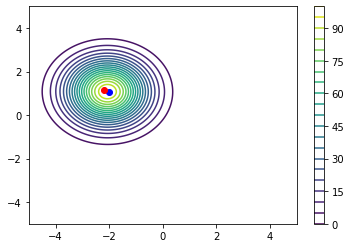

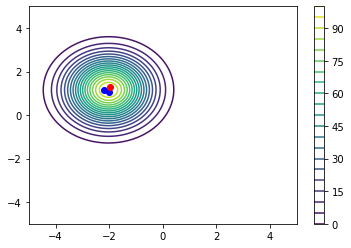

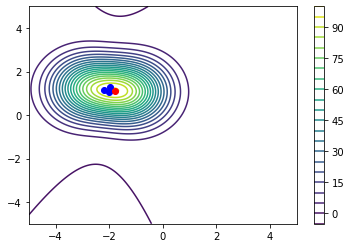

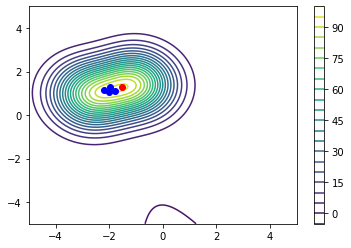

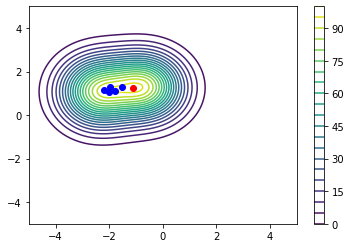

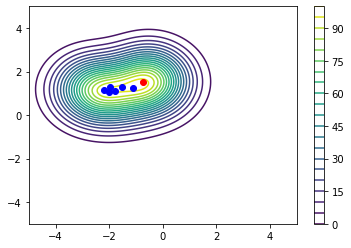

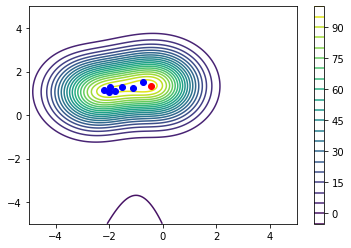

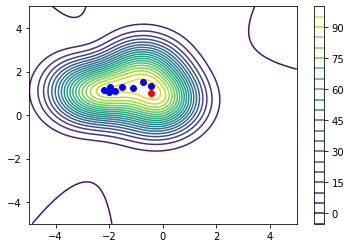

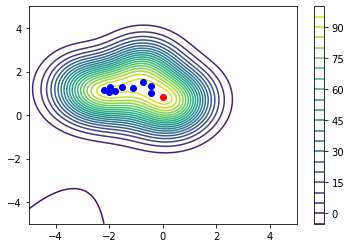

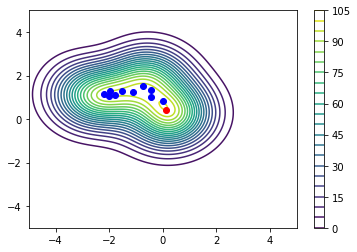

In [7]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

Estimated maximum = (array([0.03006012, 0.59118236]), 100.48207985719161) true_y = 99.64959980080401
Max found: 99.81425777406517
Number of failures: 0


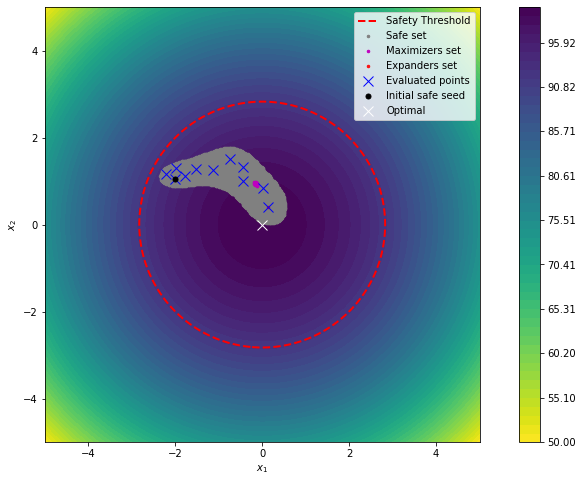

In [8]:
safeopt_stats(opt, fun)
plot_all(x_steps, x_steps, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

evals=12	y=99.59498154625885	safe=True
evals=13	y=99.62389709278276	safe=True
evals=14	y=99.01104814840102	safe=True
evals=15	y=98.76767563182477	safe=True
evals=16	y=97.46486961899751	safe=True
evals=17	y=97.33715928851692	safe=True
evals=18	y=95.96849008638519	safe=True
evals=19	y=99.49618676230216	safe=True
evals=20	y=99.40381765535078	safe=True
evals=21	y=98.16526841257665	safe=True
evals=22	y=98.32189428958117	safe=True
evals=23	y=97.12671836659291	safe=True
evals=24	y=98.70984453877695	safe=True
evals=25	y=99.73072397299609	safe=True
evals=26	y=97.63354364038699	safe=True
evals=27	y=98.6102465451946	safe=True
evals=28	y=96.351621077827	safe=True
evals=29	y=94.50022289067113	safe=True
evals=30	y=98.98454223075409	safe=True
evals=31	y=97.7700892767499	safe=True
evals=32	y=97.00543371311761	safe=True
evals=33	y=97.15563391311682	safe=True
evals=34	y=95.76929409922049	safe=True
evals=35	y=96.53716250135541	safe=True
evals=36	y=96.0913811591118	safe=True
evals=37	y=96.87932980188835	s

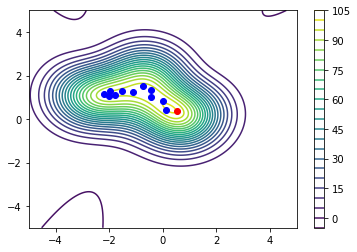

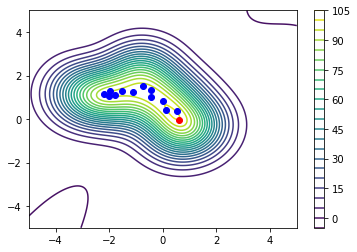

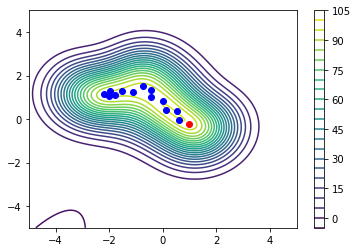

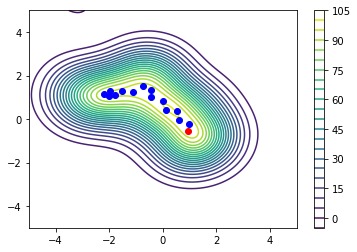

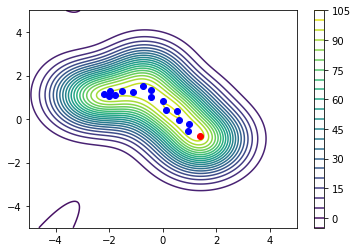

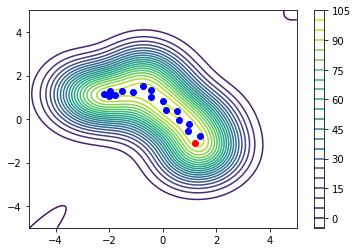

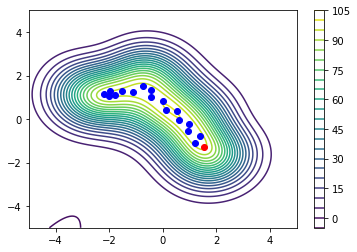

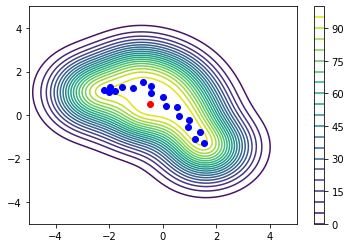

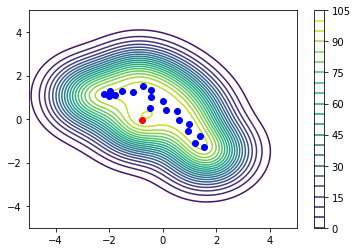

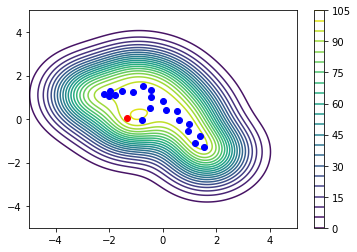

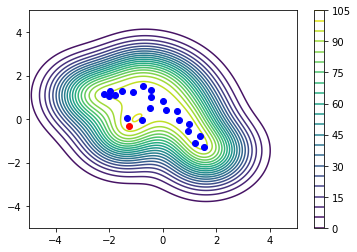

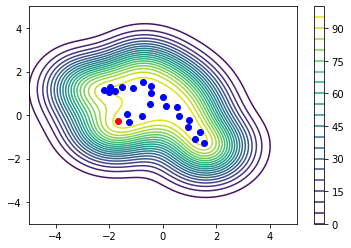

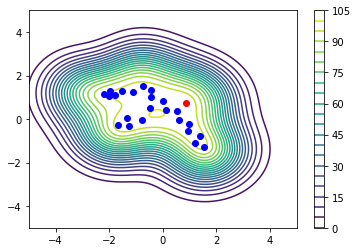

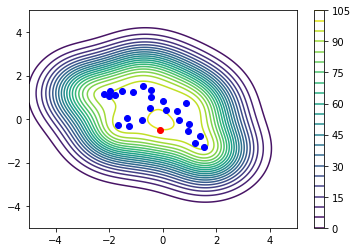

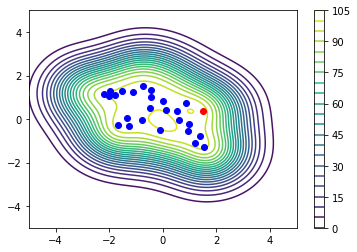

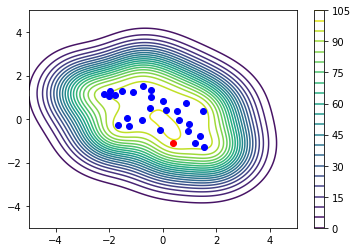

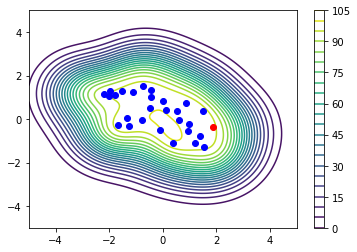

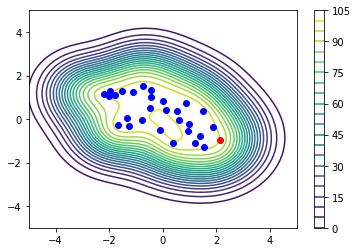

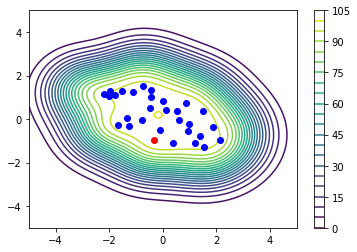

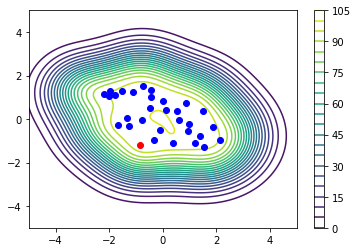

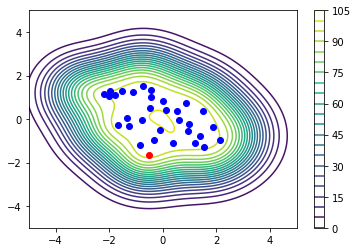

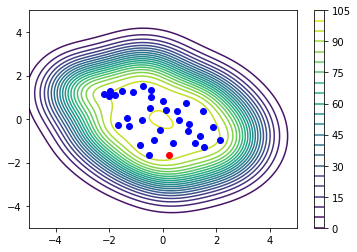

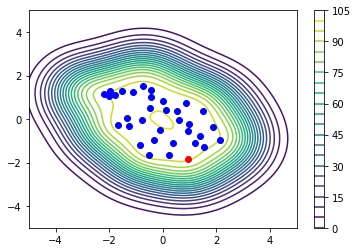

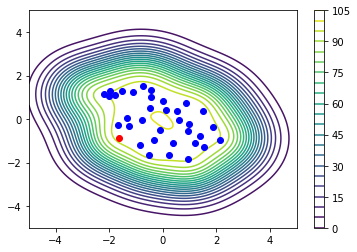

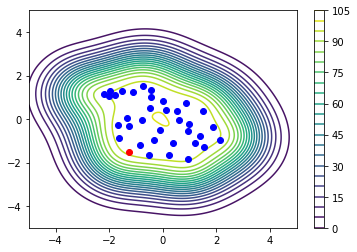

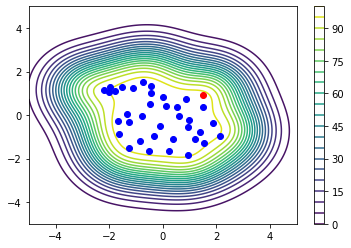

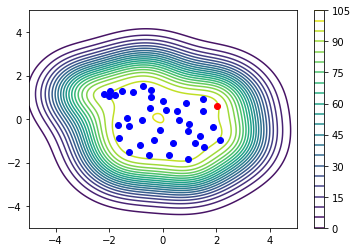

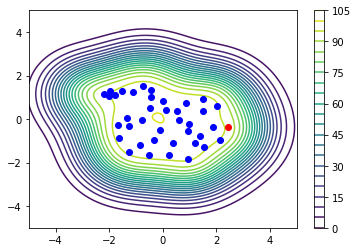

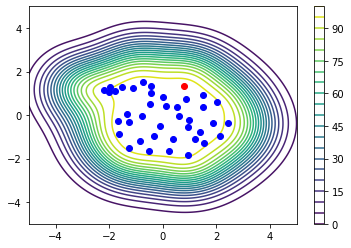

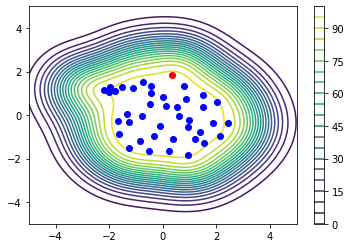

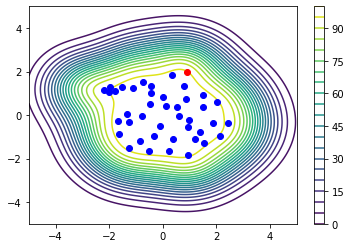

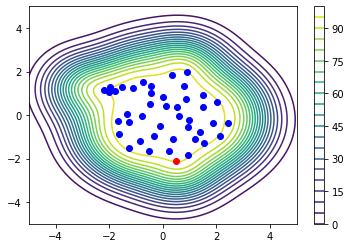

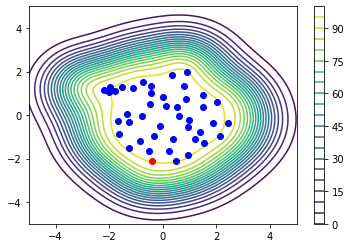

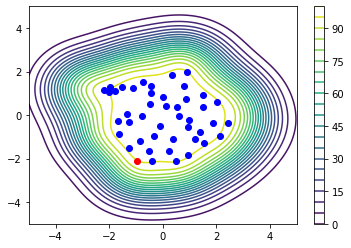

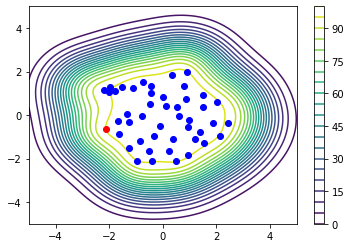

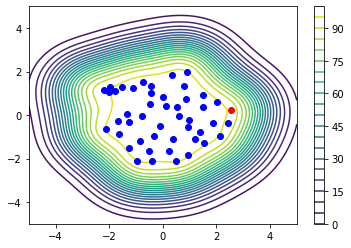

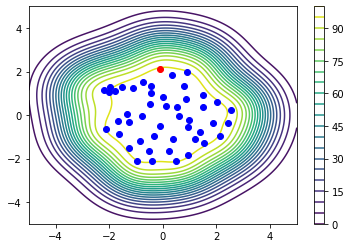

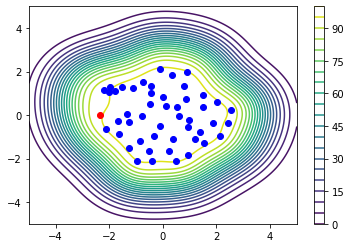

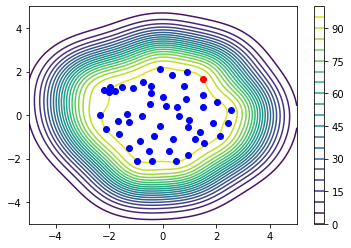

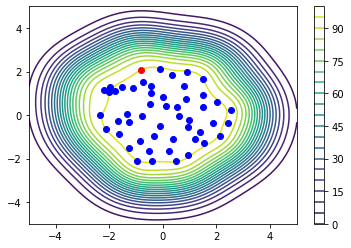

In [9]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([0.09018036, 0.1503006 ]), 99.87517436839465) true_y = 99.96927723181835
Max found: 99.81425777406517
Number of failures: 0


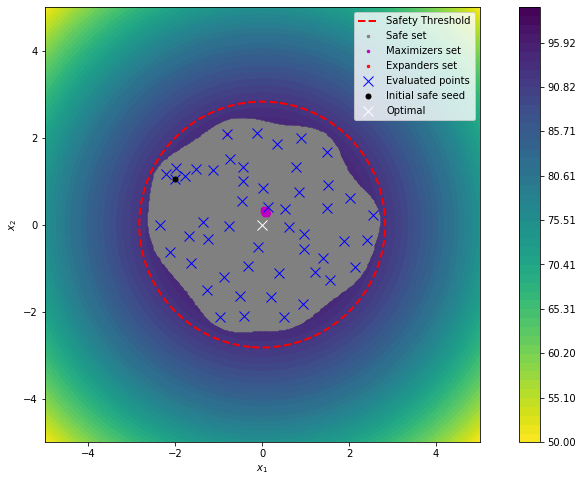

In [10]:
safeopt_stats(opt, fun)
plot_all(x_steps, x_steps, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

In [ ]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	y=94.71307344147212	safe=True
evals=53	y=94.03114846928325	safe=True
evals=54	y=93.81106903185128	safe=True
evals=55	y=94.50584535805078	safe=True
evals=56	y=94.39660884896045	safe=True
evals=57	y=94.2070513773037	safe=True
evals=58	y=94.04962229067353	safe=True
evals=59	y=93.65765599334942	safe=True
evals=60	y=92.8448078521773	safe=True
evals=61	y=93.08657394950221	safe=True
evals=62	y=94.0592608061815	safe=True
evals=63	y=93.14922430030401	safe=True
evals=64	y=93.27211537303063	safe=True
evals=65	y=93.92191196019293	safe=True
evals=66	y=93.38536793024927	safe=True
evals=67	y=92.9701085537809	safe=True
evals=68	y=93.34360102971475	safe=True
evals=69	y=93.34842028746873	safe=True
evals=70	y=92.53878498479926	safe=True
evals=71	y=93.1652884928173	safe=True
evals=72	y=93.39018718800327	safe=True
evals=73	y=92.7460130682206	safe=True
evals=74	y=93.18456552383324	safe=True
evals=75	y=92.53075288854262	safe=True
evals=76	y=92.79822169388878	safe=True
evals=77	y=92.31067345111065	sa

In [ ]:
safeopt_stats(opt, fun)
plot_all(x_steps, x_steps, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])